In [41]:
%run 'basic_functions.ipynb'


In [42]:
def plot_cv_results_comparison_by_dataset(json_file='cv_results.json'):
    """
    Create comparison charts from CV results JSON file with datasets on x-axis.
    Shows datasets vs methods with mean scores and standard deviations.
    Calculates both MAPE and RMSE from fold results automatically.
    """
    
    # Read the JSON file
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data and calculate metrics from fold results
    results_data = []
    
    def calculate_mape(actual, predictions):
        """Calculate MAPE, handling zero values"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        mask = actual != 0
        if mask.any():
            return np.mean(np.abs((actual[mask] - predictions[mask]) / actual[mask])) * 100
        else:
            return np.inf
    
    def calculate_rmse(actual, predictions):
        """Calculate RMSE"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        return np.sqrt(np.mean((actual - predictions) ** 2))
    
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            fold_results = dataset_info.get('fold_results', [])
            
            # Calculate MAPE and RMSE for each fold
            mape_scores = []
            rmse_scores = []
            
            for fold_data in fold_results:
                actual = fold_data['actual']
                predictions = fold_data['predictions']
                
                # Calculate metrics for this fold
                mape_score = calculate_mape(actual, predictions)
                rmse_score = calculate_rmse(actual, predictions)
                
                if np.isfinite(mape_score):
                    mape_scores.append(mape_score)
                if np.isfinite(rmse_score):
                    rmse_scores.append(rmse_score)
            
            # Add MAPE results
            if mape_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'mape',
                    'mean_score': np.mean(mape_scores),
                    'std_score': np.std(mape_scores),
                    'n_splits': len(mape_scores)
                })
            
            # Add RMSE results
            if rmse_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'rmse',
                    'mean_score': np.mean(rmse_scores),
                    'std_score': np.std(rmse_scores),
                    'n_splits': len(rmse_scores)
                })
    
    df = pd.DataFrame(results_data)
    
    # Separate MAPE and RMSE data
    mape_data = df[df['metric'] == 'mape'].copy()
    rmse_data = df[df['metric'] == 'rmse'].copy()

    
    # Colors for different methods
    methods = df['method'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    method_colors = dict(zip(methods, colors))
    
    # MAPE Plot
    if len(mape_data) > 0:
        plt.figure(figsize=(16, 8))
        datasets = mape_data['dataset'].unique()
        
        x_pos = np.arange(len(datasets))
        bar_width = 0.8 / len(methods) if len(methods) > 0 else 0.8
        
        for i, method in enumerate(methods):
            method_mape = mape_data[mape_data['method'] == method]
            if len(method_mape) == 0:
                continue
                
            # Get scores for each dataset (fill missing with NaN)
            scores = []
            errors = []
            for dataset in datasets:
                dataset_data = method_mape[method_mape['dataset'] == dataset]
                if len(dataset_data) > 0:
                    scores.append(dataset_data['mean_score'].iloc[0])
                    errors.append(dataset_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=method, color=method_colors[method], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Datasets', fontsize=12, fontweight='bold')
        plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        plt.title('MAPE Comparison: Datasets vs Methods', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(methods) - 1) / 2, datasets, rotation=45, ha='right')
        plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.text(0.5, 0.5, 'No MAPE data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title('MAPE Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # RMSE Plot
    if False > 0:
        plt.figure(figsize=(16, 8))
        datasets = rmse_data['dataset'].unique()
        
        x_pos = np.arange(len(datasets))
        bar_width = 0.8 / len(methods) if len(methods) > 0 else 0.8
        
        for i, method in enumerate(methods):
            method_rmse = rmse_data[rmse_data['method'] == method]
            if len(method_rmse) == 0:
                continue
                
            # Get scores for each dataset (fill missing with NaN)
            scores = []
            errors = []
            for dataset in datasets:
                dataset_data = method_rmse[method_rmse['dataset'] == dataset]
                if len(dataset_data) > 0:
                    scores.append(dataset_data['mean_score'].iloc[0])
                    errors.append(dataset_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=method, color=method_colors[method], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Datasets', fontsize=12, fontweight='bold')
        plt.ylabel('RMSE', fontsize=12, fontweight='bold')
        plt.title('RMSE Comparison: Datasets vs Methods', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(methods) - 1) / 2, datasets, rotation=45, ha='right')
        plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
    plt.show()
        
    

    
   
    return df


In [43]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

def plot_cv_results_comparison(json_file='cv_results.json'):
    """
    Create comprehensive comparison charts from CV results JSON file.
    Shows methods vs datasets with mean scores and standard deviations.
    Calculates both MAPE and RMSE from fold results automatically.
    """
    
    # Read the JSON file
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data and calculate metrics from fold results
    results_data = []
    
    def calculate_mape(actual, predictions):
        """Calculate MAPE, handling zero values"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        mask = actual != 0
        if mask.any():
            return np.mean(np.abs((actual[mask] - predictions[mask]) / actual[mask])) * 100
        else:
            return np.inf
    
    def calculate_rmse(actual, predictions):
        """Calculate RMSE"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        return np.sqrt(np.mean((actual - predictions) ** 2))
    
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            fold_results = dataset_info.get('fold_results', [])
            
            # Calculate MAPE and RMSE for each fold
            mape_scores = []
            rmse_scores = []
            
            for fold_data in fold_results:
                actual = fold_data['actual']
                predictions = fold_data['predictions']
                
                # Calculate metrics for this fold
                mape_score = calculate_mape(actual, predictions)
                rmse_score = calculate_rmse(actual, predictions)
                
                if np.isfinite(mape_score):
                    mape_scores.append(mape_score)
                if np.isfinite(rmse_score):
                    rmse_scores.append(rmse_score)
            
            # Add MAPE results
            if mape_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'mape',
                    'mean_score': np.mean(mape_scores),
                    'std_score': np.std(mape_scores),
                    'n_splits': len(mape_scores)
                })
            
            # Add RMSE results
            if rmse_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'rmse',
                    'mean_score': np.mean(rmse_scores),
                    'std_score': np.std(rmse_scores),
                    'n_splits': len(rmse_scores)
                })
    
    df = pd.DataFrame(results_data)
    
    # Separate MAPE and RMSE data
    mape_data = df[df['metric'] == 'mape'].copy()
    rmse_data = df[df['metric'] == 'rmse'].copy()

    
    # Colors for different datasets
    datasets = df['dataset'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(datasets)))
    dataset_colors = dict(zip(datasets, colors))
    
    # MAPE Plot
    if len(mape_data) > 0:
        plt.figure(figsize=(16, 8))
        methods = mape_data['method'].unique()
        
        x_pos = np.arange(len(methods))
        bar_width = 0.8 / len(datasets) if len(datasets) > 0 else 0.8
        
        for i, dataset in enumerate(datasets):
            dataset_mape = mape_data[mape_data['dataset'] == dataset]
            if len(dataset_mape) == 0:
                continue
                
            # Get scores for each method (fill missing with NaN)
            scores = []
            errors = []
            for method in methods:
                method_data = dataset_mape[dataset_mape['method'] == method]
                if len(method_data) > 0:
                    scores.append(method_data['mean_score'].iloc[0])
                    errors.append(method_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=dataset, color=dataset_colors[dataset], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Methods', fontsize=12, fontweight='bold')
        plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        plt.title('MAPE Comparison: Methods vs Datasets', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(datasets) - 1) / 2, methods, rotation=45, ha='right')
        plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
   
    # RMSE Plot
   
    


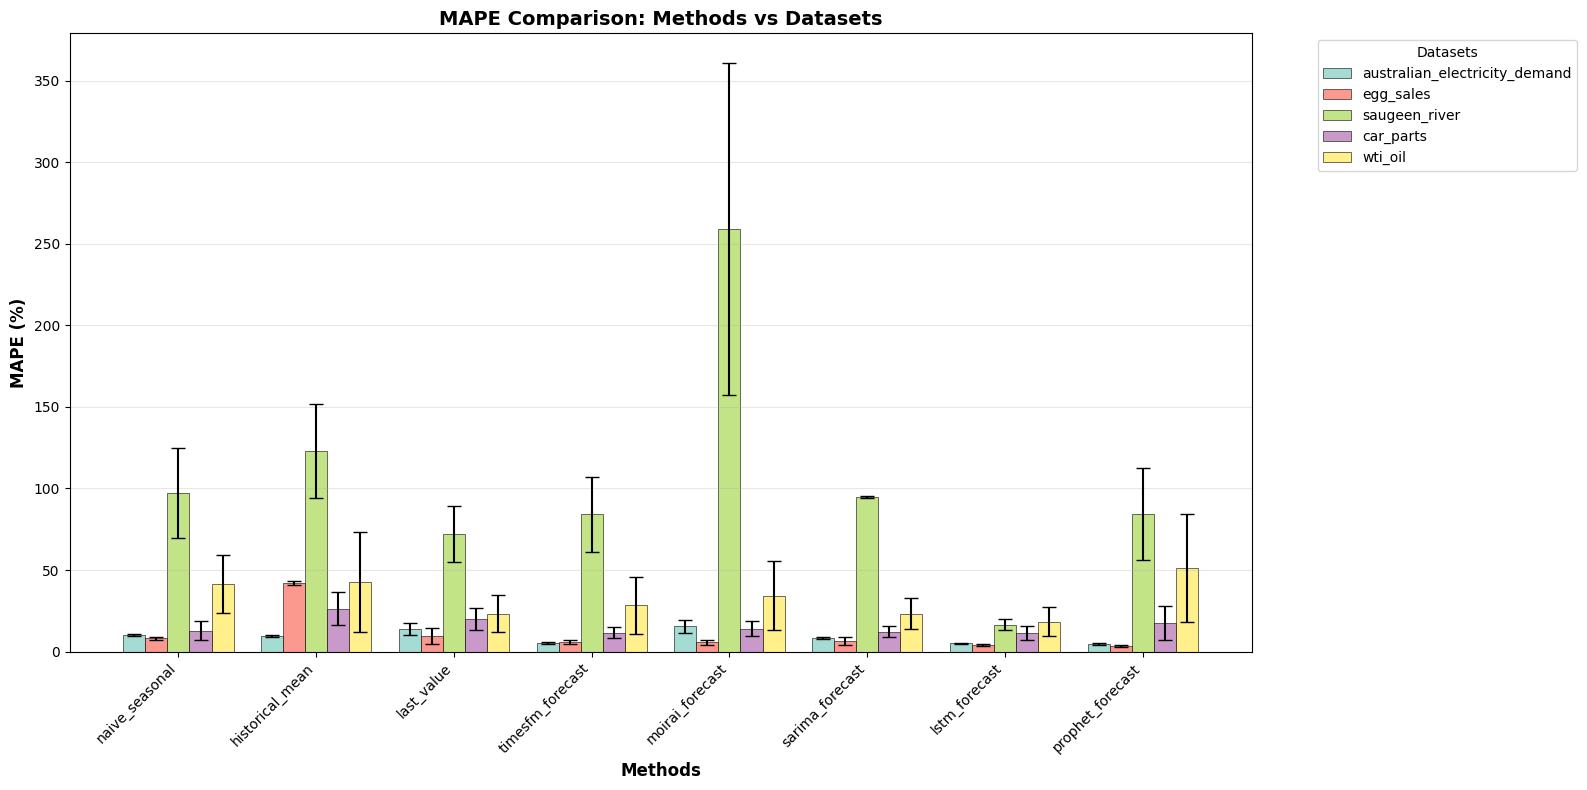

In [44]:
plot_cv_results_comparison()


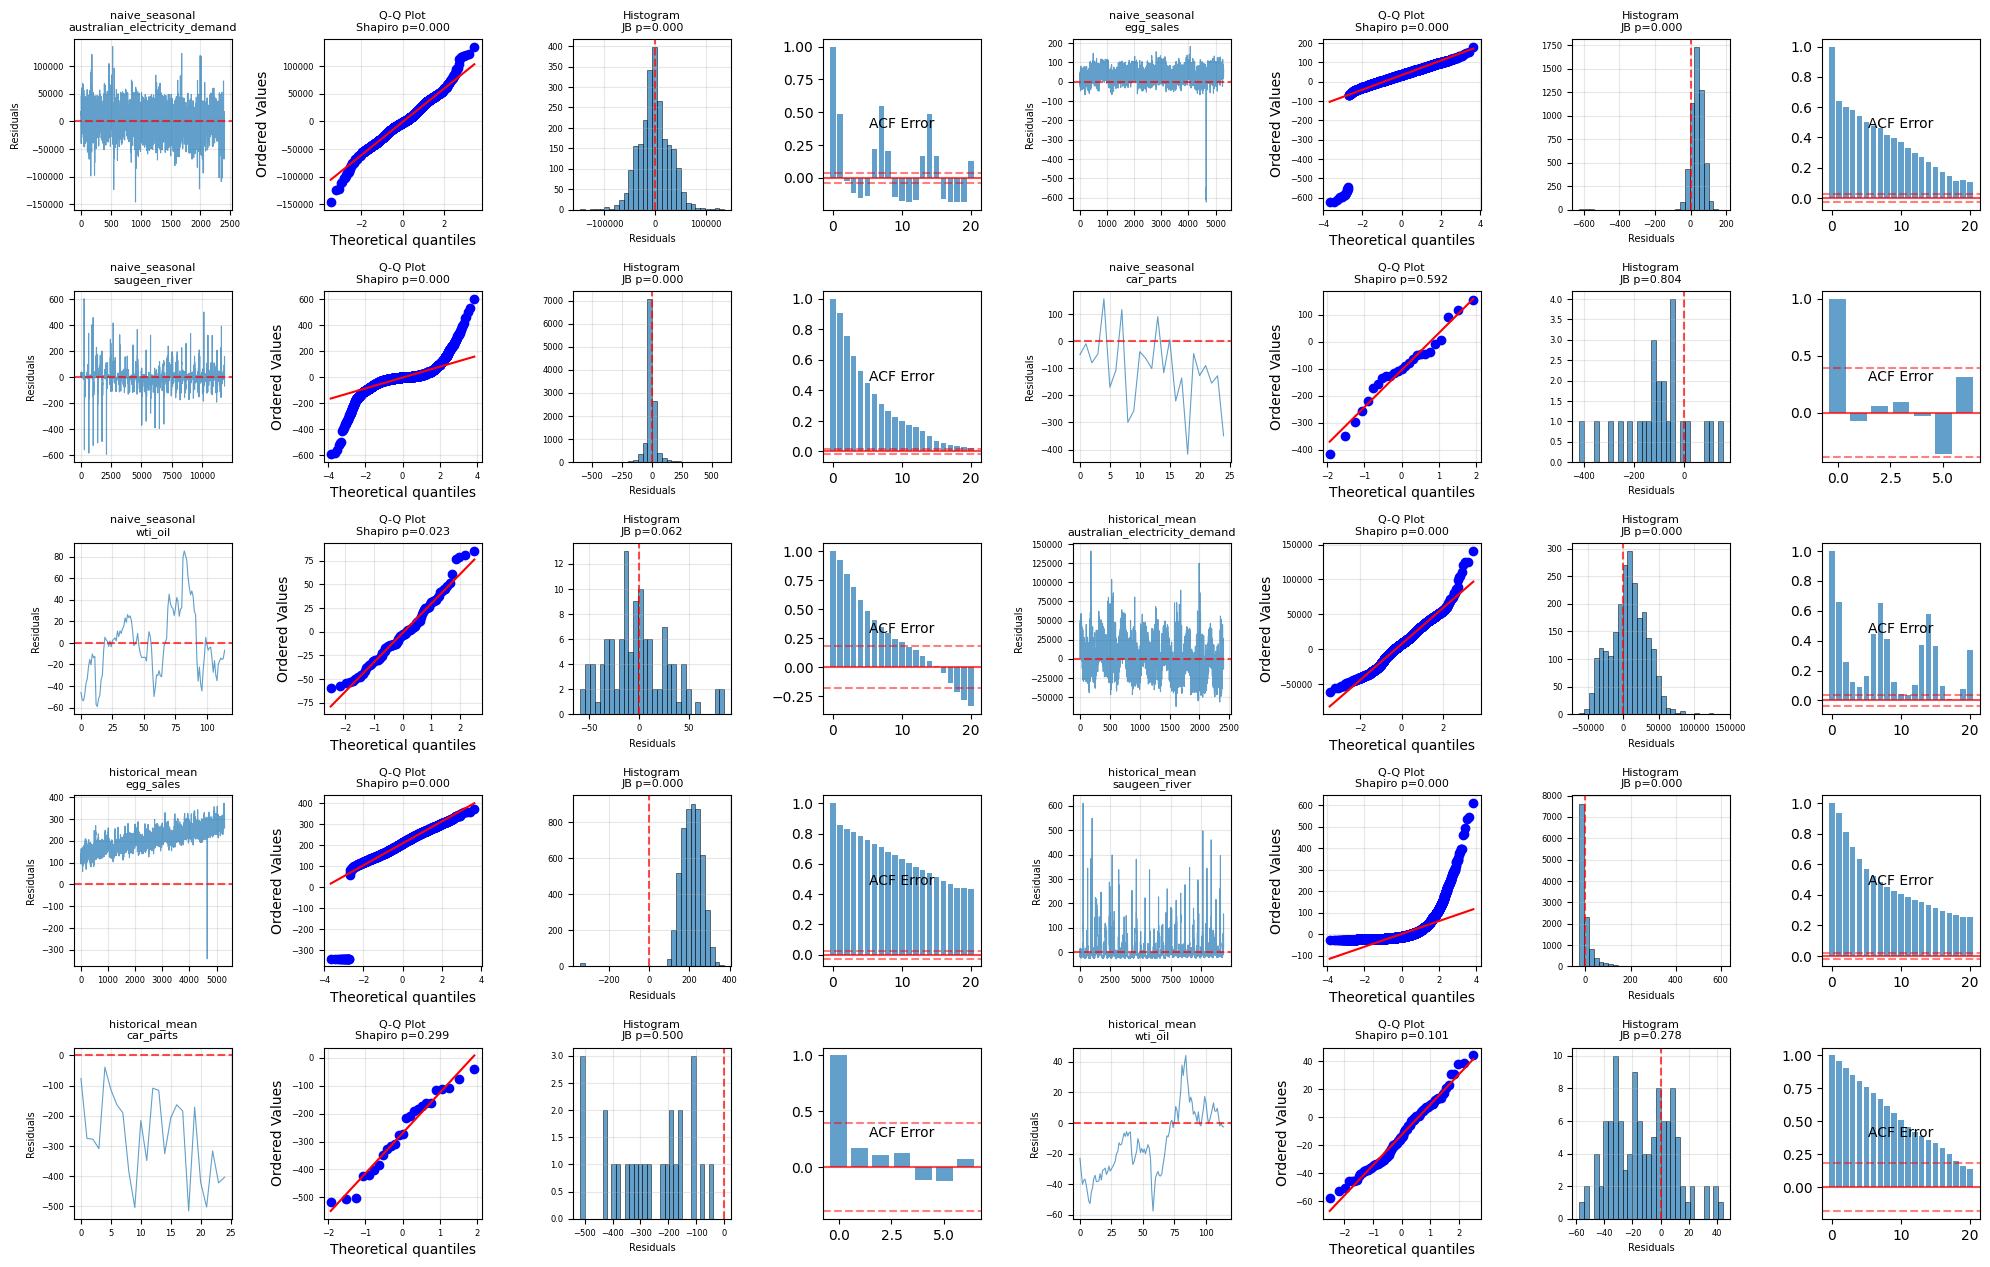

RESIDUAL ANALYSIS SUMMARY
Statistical Tests (p-values):
- Ljung-Box: Tests for autocorrelation (p > 0.05 = good)
- Shapiro-Wilk: Tests for normality (p > 0.05 = normal)
- Jarque-Bera: Tests for normality (p > 0.05 = normal)
- Durbin-Watson: ~2.0 = no autocorrelation, <2 = positive autocorr, >2 = negative autocorr

Dataset: australian_electricity_demand
--------------------------------------------------


ValueError: Unknown format code 'f' for object of type 'str'

In [45]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

def comprehensive_residual_analysis(json_file='cv_results.json'):
    """
    Comprehensive time series residual analysis for all models and datasets.
    Tests normality, autocorrelation, and other residual properties.
    """
    
    with open(json_file, 'r') as f:
        cv_data = json.load(f)
    
    # Extract all residuals
    all_residuals = {}
    
    for method_name, datasets_list in cv_data.items():
        all_residuals[method_name] = {}
        for dataset_info in datasets_list:
            dataset_name = dataset_info['dataset_name']
            fold_results = dataset_info.get('fold_results', [])
            
            # Combine residuals from all folds
            combined_residuals = []
            for fold_data in fold_results:
                actual = np.array(fold_data['actual'])
                predictions = np.array(fold_data['predictions'])
                residuals = actual - predictions
                combined_residuals.extend(residuals)
            
            if combined_residuals:
                all_residuals[method_name][dataset_name] = np.array(combined_residuals)
    
    # Perform analysis for each method-dataset combination
    results_summary = []
    
    fig = plt.figure(figsize=(20, 25))
    plot_idx = 1
    
    for method in all_residuals.keys():
        for dataset in all_residuals[method].keys():
            residuals = all_residuals[method][dataset]
            
            # Statistical tests
            ljung_box_stat, ljung_box_p = acorr_ljungbox(residuals, lags=min(10, len(residuals)//4), return_df=False)
            shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
            jb_stat, jb_p = stats.jarque_bera(residuals)
            
            # Durbin-Watson test for autocorrelation
            dw_stat = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
            
            results_summary.append({
                'method': method,
                'dataset': dataset,
                'ljung_box_p': ljung_box_p.iloc[-1] if hasattr(ljung_box_p, 'iloc') else ljung_box_p,
                'shapiro_p': shapiro_p,
                'jarque_bera_p': jb_p,
                'durbin_watson': dw_stat,
                'mean_residual': np.mean(residuals),
                'std_residual': np.std(residuals),
                'skewness': stats.skew(residuals),
                'kurtosis': stats.kurtosis(residuals)
            })
            
            # Create subplot for this method-dataset combination
            if plot_idx <= 40:  # Limit to prevent overcrowding
                
                # Residuals vs time plot
                plt.subplot(10, 8, plot_idx)
                plt.plot(residuals, alpha=0.7, linewidth=0.8)
                plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
                plt.title(f'{method}\n{dataset}', fontsize=8)
                plt.ylabel('Residuals', fontsize=7)
                plt.tick_params(labelsize=6)
                plt.grid(True, alpha=0.3)
                
                # Q-Q plot
                plt.subplot(10, 8, plot_idx + 1)
                stats.probplot(residuals, dist="norm", plot=plt)
                plt.title(f'Q-Q Plot\nShapiro p={shapiro_p:.3f}', fontsize=8)
                plt.tick_params(labelsize=6)
                plt.grid(True, alpha=0.3)
                
                # Histogram
                plt.subplot(10, 8, plot_idx + 2)
                plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', linewidth=0.5)
                plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
                plt.title(f'Histogram\nJB p={jb_p:.3f}', fontsize=8)
                plt.xlabel('Residuals', fontsize=7)
                plt.tick_params(labelsize=6)
                plt.grid(True, alpha=0.3)
                
                # ACF plot
                plt.subplot(10, 8, plot_idx + 3)
                if len(residuals) > 20:
                    try:
                        acf_vals = acf(residuals, nlags=min(20, len(residuals)//4), fft=False)
                        lags = range(len(acf_vals))
                        plt.bar(lags, acf_vals, alpha=0.7)
                        plt.axhline(y=0, color='red', linestyle='-', alpha=0.7)
                        plt.axhline(y=1.96/np.sqrt(len(residuals)), color='red', linestyle='--', alpha=0.5)
                        plt.axhline(y=-1.96/np.sqrt(len(residuals)), color='red', linestyle='--', alpha=0.5)
                        plt.title(f'ACF\nLB p={ljung_box_p.iloc[-1] if hasattr(ljung_box_p, "iloc") else ljung_box_p:.3f}', fontsize=8)
                        plt.xlabel('Lag', fontsize=7)
                        plt.tick_params(labelsize=6)
                        plt.grid(True, alpha=0.3)
                    except:
                        plt.text(0.5, 0.5, 'ACF Error', ha='center', va='center', transform=plt.gca().transAxes)
                
                plot_idx += 4
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    df_results = pd.DataFrame(results_summary)
    
    # Statistical significance summary
    print("="*80)
    print("RESIDUAL ANALYSIS SUMMARY")
    print("="*80)
    print("Statistical Tests (p-values):")
    print("- Ljung-Box: Tests for autocorrelation (p > 0.05 = good)")
    print("- Shapiro-Wilk: Tests for normality (p > 0.05 = normal)")
    print("- Jarque-Bera: Tests for normality (p > 0.05 = normal)")
    print("- Durbin-Watson: ~2.0 = no autocorrelation, <2 = positive autocorr, >2 = negative autocorr")
    print()
    
    # Best performing models per dataset
    for dataset in df_results['dataset'].unique():
        dataset_results = df_results[df_results['dataset'] == dataset]
        print(f"Dataset: {dataset}")
        print("-" * 50)
        
        # Best models by different criteria
        best_ljung = dataset_results.loc[dataset_results['ljung_box_p'].idxmax()]
        best_shapiro = dataset_results.loc[dataset_results['shapiro_p'].idxmax()]
        best_mean_zero = dataset_results.loc[dataset_results['mean_residual'].abs().idxmin()]
        
        print(f"Best autocorrelation (Ljung-Box): {best_ljung['method']} (p={best_ljung['ljung_box_p']:.4f})")
        print(f"Best normality (Shapiro): {best_shapiro['method']} (p={best_shapiro['shapiro_p']:.4f})")
        print(f"Closest to zero mean: {best_mean_zero['method']} (mean={best_mean_zero['mean_residual']:.4f})")
        print()
    
    # Detailed results table
    print("\nDETAILED RESULTS:")
    print("=" * 120)
    display_df = df_results[['method', 'dataset', 'ljung_box_p', 'shapiro_p', 'jarque_bera_p', 
                            'durbin_watson', 'mean_residual', 'std_residual']].round(4)
    print(display_df.to_string(index=False))
    
    return df_results

# Run the analysis
residual_results = comprehensive_residual_analysis()
